## Setup

Import modules

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport
import sweetviz as sv
from scipy.stats import pearsonr

Define constants and import dataset

In [116]:
DATASET = '../udataset/filtered_stock_and_etfs.csv'
START_DATE = '2010-01'
END_DATE = '2022-12'

df = pd.read_csv(DATASET)

## Exploratory Data Analysis

Generate Profile report for the dataset using `ydata-profiling` library

Generate a profile report using the `sweetviz` library

Plot time series data of coca cola stock

Plot time series data of S&P500 index

## Create metric for growth

Convert the date column to date type

In [117]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df['YearMonth'] = df['Date-Time'].dt.to_period('M')

Sort the dataframe by ticker symbol and date

In [118]:
df = df.sort_values(by=['Ticker_Symbol', 'Date-Time'])

Get the monthly opening price for each stock and the opening price the previous month

In [119]:
month_open_prices = df.groupby(['Ticker_Symbol', 'YearMonth'])['Open'].first().reset_index()

month_open_prices['Prev_First_Open'] = month_open_prices.groupby('Ticker_Symbol')['Open'].shift(1)

Calculate the monthly growth for each stock

In [120]:
month_open_prices['Monthly_Growth (%)'] = ((month_open_prices['Open'] - month_open_prices['Prev_First_Open']) / month_open_prices['Prev_First_Open']) * 100

Calculate the cumulative monthly growth for each stock

In [121]:
month_open_prices['Cumulative_Growth (%)'] = month_open_prices.groupby('Ticker_Symbol')['Monthly_Growth (%)'].cumsum()

Drop the first row of each stock

In [122]:
growth = month_open_prices.dropna(subset=['Prev_First_Open'])
#growth['YearMonth']-=1

growth.to_csv('../udataset/stock_growth_month.csv', index=False)

## Plot growth for each symbol

/tmp/ipykernel_1212/214737088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display_data['YearMonth_str'] = display_data['YearMonth'].astype(str)
/home/cdv/Datathon/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cdv/Datathon/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cdv/Datathon/.venv/lib/python3.10/site-packa

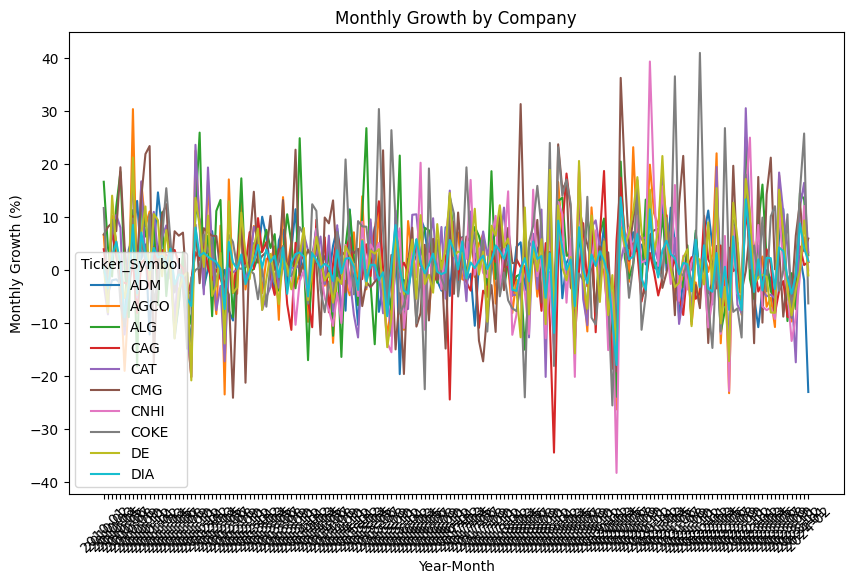

In [123]:
display_data = growth[growth['YearMonth'] >= pd.Period(START_DATE)]

display_data['YearMonth_str'] = display_data['YearMonth'].astype(str)

company_subset = display_data['Ticker_Symbol'].unique()[:10] # First 10 companies
plot_data = display_data[display_data['Ticker_Symbol'].isin(company_subset)]


plt.figure(figsize=(10, 6)) # TODO - Note that graph is not well labeled
sns.lineplot(data=plot_data, x='YearMonth_str', y='Monthly_Growth (%)', hue='Ticker_Symbol')
plt.xticks(rotation=45)
plt.title('Monthly Growth by Company')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Growth (%)')
plt.show()

In [124]:
MARKETCAP = '../udataset/market_cap.csv'
cap_df = pd.read_csv(MARKETCAP)
cap_df['YearMonth'] = pd.to_datetime(cap_df['YearMonth'])
cap_df['YearMonth'] = cap_df['YearMonth'].dt.to_period('M')
fast_food_tickers = ['WEN', 'YUM', 'MCD', 'CMG', 'DPZ']
#fast_food_tickers = ['YUM']
manufacturers = ['COKE', 'CAG', 'HRL', 'GIS', 'MNST', 'PEP', 'KDP', 'TSN', 'ADN', 'HSY', 'VMI', 'PPC']

#cap_df = cap_df[cap_df['Ticker'].isin(fast_food_tickers)]


In [125]:
# growth = pd.merge()
print(cap_df.columns)
cap_df = cap_df.rename(columns = {'Ticker': 'Ticker_Symbol'})
growth = pd.merge(growth, cap_df, on = ['YearMonth', 'Ticker_Symbol'], how='left')

Index(['YearMonth', 'Ticker', 'MarketCap'], dtype='object')


In [126]:
growth = growth[growth['YearMonth'] >= pd.Period(START_DATE)]
growth
#growth['market_cap'] = growth.apply(get_market_cap, axis=1)


Ticker_Symbol YearMonth    Open  Prev_First_Open  Monthly_Growth (%)  \
121            ADM   2010-01   31.48           31.250            0.736000   
122            ADM   2010-02   30.07           31.480           -4.479034   
123            ADM   2010-03   29.49           30.070           -1.928833   
124            ADM   2010-04   28.97           29.490           -1.763310   
125            ADM   2010-05   28.23           28.970           -2.554367   
...            ...       ...     ...              ...                 ...   
7780           YUM   2023-10  124.53          129.925           -4.152396   
7781           YUM   2023-11  121.88          124.530           -2.128001   
7782           YUM   2023-12  125.59          121.880            3.043978   
7783           YUM   2024-01  129.73          125.590            3.296441   
7784           YUM   2024-02  129.31          129.730           -0.323749   

      Cumulative_Growth (%)     MarketCap  
121              146.566170  1.927070e+10  
122              142.087136  1.886650e+10  
123              140.158303  1.858270e+10  
124              138.394994  1.796680e+10  
125              135.840627  1.624990e+10  
...                     ...           ...  
7780             243.938298  3.347400e+10  
7781             241.810297  3.540190e+10  
7782             244.854274  3.569160e+10  
7783             248.150715  3.597470e+10  
7784             247.826966  3.608970e+10  

[4816 rows x 7 columns]

In [127]:
growth['MarketCap_growth'] = growth['MarketCap']*growth['Monthly_Growth (%)']
print(growth.columns)

Index(['Ticker_Symbol', 'YearMonth', 'Open', 'Prev_First_Open',
       'Monthly_Growth (%)', 'Cumulative_Growth (%)', 'MarketCap',
       'MarketCap_growth'],
      dtype='object')


In [128]:
def get_stock_growth(stock, df):
    def get_growth(row):

        stock_growth = df[(df['Ticker_Symbol'] == stock) & (df['YearMonth'] == row['year-month'])]['Monthly_Growth (%)']

        if len(stock_growth) == 0:
            return np.nan

        stock_growth = np.array(stock_growth)
        return stock_growth[0]

    return get_growth


In [129]:
overall_growth = []
year_month = []
start_year = int(START_DATE[:4])
end_year = int(END_DATE[:4])+1
for year in range(start_year, end_year):
    for month in range(1, 13):
        month_string = str(month)
        if len(month_string) == 1:
            month_string = '0' + month_string

        date_string = f'{str(year)}-{month_string}'
        year_month.append(date_string)

        overall_growth.append(growth[growth['YearMonth'] == pd.Period(date_string)]['MarketCap_growth'].sum()/growth[growth['YearMonth'] == pd.Period(date_string)]['MarketCap'].sum())

new_df = pd.DataFrame({'year-month': year_month, 'S&P_growth': growth[(growth['Ticker_Symbol'] == 'SPY') & (growth['YearMonth'] >= pd.Period(START_DATE)) & (growth['YearMonth'] <= pd.Period(END_DATE))]['Monthly_Growth (%)']})

for stock in cap_df['Ticker_Symbol'].unique():
    desired_growth = new_df.apply(get_stock_growth(stock, growth), axis=1)
    #new_df[f'{stock}-growth_diff'] = desired_growth
    new_df[f'{stock}-growth_diff'] = (new_df['S&P_growth'] - desired_growth)/(((desired_growth)+new_df['S&P_growth'])/2)

new_df['processed_food_growth'] = overall_growth
new_df['growth_diff'] = (new_df['S&P_growth'] - new_df['processed_food_growth'])/(((new_df['processed_food_growth'])+new_df['S&P_growth'])/2)
new_df

year-month  S&P_growth  QSR-growth_diff  ALG-growth_diff  \
5999    2010-01    1.307248              NaN        -1.709260   
6000    2010-02   -3.755451              NaN       -28.478731   
6001    2010-03    2.820157              NaN         5.029798   
6002    2010-04    5.935252              NaN        -0.673978   
6003    2010-05    1.341256              NaN        -1.730031   
...         ...         ...              ...              ...   
6150    2022-08    8.654663         0.367502        -0.081763   
6151    2022-09   -3.974093        -4.660381         5.298880   
6152    2022-10   -8.096414        -0.010057         0.357879   
6153    2022-11    8.048078        -0.325344        -1.029238   
6154    2022-12    4.775209        -0.803533         4.190134   

      SBUX-growth_diff  CAG-growth_diff  HRL-growth_diff  DPZ-growth_diff  \
5999         -1.290163        -1.002308        -0.636814        -1.452804   
6000         -0.384177         0.743267         3.228990        -2.506534   
6001         -0.410021        -0.900522        -0.760249        -1.177585   
6002         -0.167654         0.779269         1.025070        -0.396967   
6003         -1.272265        -6.966055        -5.729594        -1.637635   
...                ...              ...              ...              ...   
6150         -0.116204         2.096773         0.684808         2.036828   
6151          1.489023         2.611233         0.002037        -0.347594   
6152          2.733407         0.610693         0.719164        -0.652740   
6153          0.693087        -0.332397         1.284748         0.084993   
6154         -1.089572         0.165077         1.205227        -1.125994   

      CMG-growth_diff  DRI-growth_diff  ...  KDP-growth_diff  PEP-growth_diff  \
5999        -1.346320        -1.593360  ...              NaN        -6.887343   
6000        -5.429080       -16.044244  ...              NaN         0.583458   
6001        -1.038923        -1.082522  ...              NaN        -0.467053   
6002        -0.210880        -0.524501  ...              NaN         0.013111   
6003        -1.741617         1.001102  ...              NaN       -25.645094   
...               ...              ...  ...              ...              ...   
6150        -0.779151        -0.004461  ...              NaN         0.595373   
6151         3.940034         1.570846  ...              NaN         0.625907   
6152         0.653860         4.836669  ...              NaN         0.606286   
6153         2.083447        -0.510677  ...              NaN        -0.278597   
6154        -0.445096         0.710071  ...              NaN         0.622182   

      CNHI-growth_diff  MNST-growth_diff  WEN-growth_diff  DE-growth_diff  \
5999               NaN               NaN        -1.669051        0.365553   
6000               NaN               NaN        -0.011126       -0.720312   
6001               NaN               NaN        -0.676280       -1.331564   
6002               NaN               NaN         0.354177        0.292380   
6003               NaN               NaN        -1.201603        0.628146   
...                ...               ...              ...             ...   
6150          0.045609               NaN        -0.276176       -0.381521   
6151         -0.114118               NaN        -0.766876      -10.109001   
6152          0.554894               NaN         1.520648        0.400314   
6153         -0.587748               NaN        -0.299329       -0.724619   
6154         -1.358908               NaN        -0.526277       -0.760562   

      CAT-growth_diff  COKE-growth_diff  processed_food_growth  growth_diff  
5999        -5.798074         -1.598658               0.013414     1.959373  
6000        -0.761966         -0.181370              -2.020718     0.600652  
6001        -1.006864         -1.083850               3.823627    -0.302078  
6002        -0.546280          0.124155               6.388487    -0.073555  
6003       

In [130]:
UNEMPLOYMENTDATA = '../udataset/unemployment_month_US.csv'
unemployment_df = pd.read_csv(UNEMPLOYMENTDATA)
unemployment_df.columns = unemployment_df.columns.str.strip()
unemployment_df.columns = unemployment_df.columns.str.lower()

In [131]:
POVERTYDATA = '../udataset/State_Data.csv'
state_df = pd.read_csv(POVERTYDATA)
state_df.dtypes


state                                                                                           object
year                                                                                             int64
below_poverty_line_percent                                                                     float64
median_household_income                                                                        float64
mean cash public assistance income (dollars)                                                   float64
agriculture, forestry, fishing and hunting, and mining                                         float64
construction                                                                                   float64
manufacturing                                                                                  float64
wholesale trade                                                                                float64
retail trade                                                             

In [132]:
#unemployment_rate = [9.63, 8.95, 8.07, 7.37, 6.17, 5.28, 4.87, 4.36, 3.90, 3.67, 8.05, 5.35, 3.61]
new_df = pd.merge(new_df, unemployment_df, on=['year-month'])
new_df = new_df.drop(columns = ['unnamed: 0'])
new_df
#print(new_df['unemployment_rate'].expanding().corr(new_df['S&P_growth']))

year-month  S&P_growth  QSR-growth_diff  ALG-growth_diff  \
0      2010-01    1.307248              NaN        -1.709260   
1      2010-02   -3.755451              NaN       -28.478731   
2      2010-03    2.820157              NaN         5.029798   
3      2010-04    5.935252              NaN        -0.673978   
4      2010-05    1.341256              NaN        -1.730031   
..         ...         ...              ...              ...   
151    2022-08    8.654663         0.367502        -0.081763   
152    2022-09   -3.974093        -4.660381         5.298880   
153    2022-10   -8.096414        -0.010057         0.357879   
154    2022-11    8.048078        -0.325344        -1.029238   
155    2022-12    4.775209        -0.803533         4.190134   

     SBUX-growth_diff  CAG-growth_diff  HRL-growth_diff  DPZ-growth_diff  \
0           -1.290163        -1.002308        -0.636814        -1.452804   
1           -0.384177         0.743267         3.228990        -2.506534   
2           -0.410021        -0.900522        -0.760249        -1.177585   
3           -0.167654         0.779269         1.025070        -0.396967   
4           -1.272265        -6.966055        -5.729594        -1.637635   
..                ...              ...              ...              ...   
151         -0.116204         2.096773         0.684808         2.036828   
152          1.489023         2.611233         0.002037        -0.347594   
153          2.733407         0.610693         0.719164        -0.652740   
154          0.693087        -0.332397         1.284748         0.084993   
155         -1.089572         0.165077         1.205227        -1.125994   

     CMG-growth_diff  DRI-growth_diff  ...  PEP-growth_diff  CNHI-growth_diff  \
0          -1.346320        -1.593360  ...        -6.887343               NaN   
1          -5.429080       -16.044244  ...         0.583458               NaN   
2          -1.038923        -1.082522  ...        -0.467053               NaN   
3          -0.210880        -0.524501  ...         0.013111               NaN   
4          -1.741617         1.001102  ...       -25.645094               NaN   
..               ...              ...  ...              ...               ...   
151        -0.779151        -0.004461  ...         0.595373          0.045609   
152         3.940034         1.570846  ...         0.625907         -0.114118   
153         0.653860         4.836669  ...         0.606286          0.554894   
154         2.083447        -0.510677  ...        -0.278597         -0.587748   
155        -0.445096         0.710071  ...         0.622182         -1.358908   

     MNST-growth_diff  WEN-growth_diff  DE-growth_diff  CAT-growth_diff  \
0                 NaN        -1.669051        0.365553        -5.798074   
1                 NaN        -0.011126       -0.720312        -0.761966   
2                 NaN        -0.676280       -1.331564        -1.006864   
3                 NaN         0.354177        0.292380        -0.546280   
4                 NaN        -1.201603        0.628146        -1.427291   
..                ...              ...             ...              ...   
151               NaN        -0.276176       -0.381521        -0.016065   
152               NaN        -0.766876      -10.109001        -0.491896   
153               NaN         1.520648        0.400314        -0.005586   
154               NaN        -0.299329       -0.724619        -1.166607   
155               NaN        -0.526277       -0.760562        -0.545451   

     COKE-growth_diff  processed_food_growth  growth_diff  unemployment_rate  
0           -1.598658               0.013414     1.959373                9.8  
1           -0.181370              -2.020718     0.600652                9.8  
2           -1.083850               3.823627    -0.302078                9.9  
3            0.124155               6.388487    -0.073555                9.9  
4           -3.138186               2.321115    -0.53

In [133]:
#print(new_df[new_df.columns[1:]].corr())
new_df['expanding_correlation'] = new_df['unemployment_rate'].expanding().corr(new_df['growth_diff'])


print(new_df.columns)


Index(['year-month', 'S&P_growth', 'QSR-growth_diff', 'ALG-growth_diff',
       'SBUX-growth_diff', 'CAG-growth_diff', 'HRL-growth_diff',
       'DPZ-growth_diff', 'CMG-growth_diff', 'DRI-growth_diff',
       'GIS-growth_diff', 'TSCO-growth_diff', 'MCD-growth_diff',
       'PPC-growth_diff', 'VMI-growth_diff', 'YUM-growth_diff',
       'SAP-growth_diff', 'HSY-growth_diff', 'ADM-growth_diff',
       'TSN-growth_diff', 'AGCO-growth_diff', 'KDP-growth_diff',
       'PEP-growth_diff', 'CNHI-growth_diff', 'MNST-growth_diff',
       'WEN-growth_diff', 'DE-growth_diff', 'CAT-growth_diff',
       'COKE-growth_diff', 'processed_food_growth', 'growth_diff',
       'unemployment_rate', 'expanding_correlation'],
      dtype='object')


In [134]:
p_value_df = pd.DataFrame({'stock': new_df.columns[1:-2]})
p_values = []
r_values = []

for col in new_df.columns[1:-2]:
    if len(new_df[pd.notna(new_df[col])][col]) < 2:
        p_values.append(np.nan)
        r_values.append(np.nan)
        continue

    stats = pearsonr(new_df[pd.notna(new_df[col])][col], new_df[pd.notna(new_df[col])]['unemployment_rate'])
    p_values.append(stats[1])
    r_values.append(stats[0])

p_value_df['p_value'] = p_values
p_value_df['r_value'] = r_values

p_value_df

stock   p_value   r_value
0              S&P_growth  0.610357  0.041111
1         QSR-growth_diff  0.642962 -0.047913
2         ALG-growth_diff  0.972727 -0.002759
3        SBUX-growth_diff  0.289803 -0.085283
4         CAG-growth_diff  0.938982 -0.006178
5         HRL-growth_diff  0.784499 -0.022069
6         DPZ-growth_diff  0.888551 -0.011311
7         CMG-growth_diff  0.916178 -0.008495
8         DRI-growth_diff  0.638274  0.037931
9         GIS-growth_diff  0.971507 -0.002883
10       TSCO-growth_diff  0.510216 -0.053112
11        MCD-growth_diff  0.379442 -0.070852
12        PPC-growth_diff  0.469645  0.058311
13        VMI-growth_diff  0.958845 -0.004165
14        YUM-growth_diff  0.080156  0.140529
15        SAP-growth_diff  0.657476 -0.035777
16        HSY-growth_diff  0.226052 -0.097478
17        ADM-growth_diff  0.382196  0.070444
18        TSN-growth_diff  0.152595  0.115070
19       AGCO-growth_diff  0.088260 -0.136939
20        KDP-growth_diff       NaN       NaN
21        PEP-growth_diff  0.328926 -0.078676
22       CNHI-growth_diff  0.466787  0.069778
23       MNST-growth_diff       NaN       NaN
24        WEN-growth_diff  0.215517 -0.099717
25         DE-growth_diff  0.826525 -0.017688
26        CAT-growth_diff  0.546215  0.048677
27       COKE-growth_diff  0.198900 -0.103413
28  processed_food_growth  0.651062  0.036493
29            growth_diff  0.672255 -0.034136

In [135]:
new_df.to_csv('../udataset/growth_vs_unemployment_month.csv')